In [1]:
from vis import barplot, recompute
import seaborn as sns 

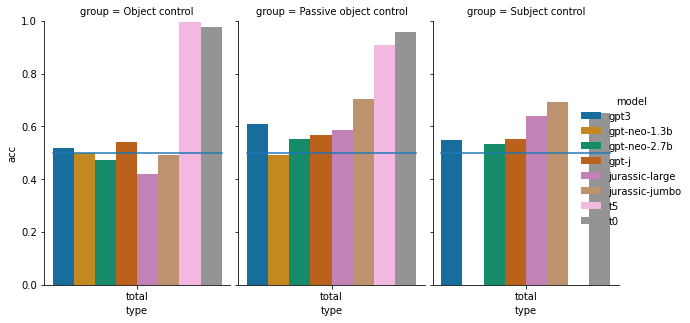

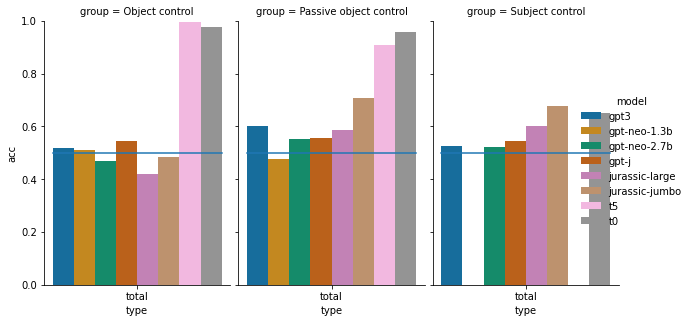

In [10]:


oc_csvs=["../results_to_plot/gpt_object_control_swap_names.csv", 
     "../results_to_plot/gpt_neo_1.3B_object_control.csv", 
     "../results_to_plot/gpt_neo_2.7b_object_control.csv", 
     "../results_to_plot/gpt_j_object_control.csv", 
     "../results_to_plot/jurassic_object_control_swap_names.csv", 
     "../results_to_plot/jurassic_jumbo_object_control_swap_names.csv", 
     "../results_to_plot/t5_object_control.csv",
     "../results_to_plot/t0_object_control.csv"]

sc_csvs=["../results_to_plot/gpt_subject_control_swap_names.csv", 
     "../results_to_plot/gpt_neo_1.3B_subject_control.csv",
     "../results_to_plot/gpt_neo_2.7b_subject_control.csv", 
     "../results_to_plot/gpt_j_subject_control.csv",
     "../results_to_plot/jurassic_subject_control_swap_names.csv", 
     "../results_to_plot/jurassic_jumbo_subject_control_swap_names.csv", 
     "../results_to_plot/t5_subject_control.csv",
     "../results_to_plot/t0_subject_control.csv"]

poc_csvs=["../results_to_plot/gpt_passive_object_control_swap_names.csv", 
     "../results_to_plot/gpt_neo_1.3B_passive_object_control.csv",
     "../results_to_plot/gpt_neo_2.7b_passive_object_control.csv",
     "../results_to_plot/gpt_j_passive_object_control.csv",
     "../results_to_plot/jurassic_passive_object_control_swap_names.csv", 
     "../results_to_plot/jurassic_jumbo_passive_object_control_swap_names.csv", 
     "../results_to_plot/t5_passive_object_control.csv",
     "../results_to_plot/t0_passive_object_control.csv"]

csv_data = {"Object control": oc_csvs, "Passive object control": poc_csvs, "Subject control": sc_csvs}
# csv_data = {"Object control": [oc_csvs[3]]}
# g = barplot(csv_data, level="total", x_name = "type", hue_name = "model", filtered=False)
# g.figure.set_size_inches(9.5, 4.5)

g = barplot(csv_data, level="total", x_name = "type", hue_name = "model", filtered=True)
g.figure.set_size_inches(9.5, 4.5)

g = barplot(csv_data, level="total", x_name = "type", hue_name = "model", filtered=True, ignore_first_only=True)
g.figure.set_size_inches(9.5, 4.5)

sns.despine()

In [ ]:
# Recompute Object Control with Names
import json 
import pathlib 
from experiment import Experiment
prompt=None
wrapper_fxn=None
nicknames = json.load(open("../data/nicknames.json"))
csvs = ["../results/gpt_object_control_swap_names.csv", 
     "../results/gpt_neo_1.3b_object_control.csv", 
     "../results/gpt_neo_2.7b_object_control.csv", 
     "../results/gpt_j_object_control.csv", 
     "../results/jurassic_object_control_swap_names.csv",
     "../results/jurassic_jumbo_object_control_swap_names.csv", 
     "../results/t5_object_control.csv",
     "../results/t0_object_control.csv"]

names = ["gpt", "gpt-neo-1.3b", "gpt-neo-2.7b", "gpt-j", "jurassic-large", "jurassic-jumbo", "t5_qa", "t0"]

recompute(csvs, names, nicknames, exp_name = "object-control", results_path="results_to_plot")



In [ ]:
# Recompute Passive Object Control with Names 
import json 
import pathlib 
from experiment import Experiment
prompt=None
wrapper_fxn=None
nicknames = json.load(open("../data/nicknames.json"))
csvs = ["../results/gpt_passive_object_control_swap_names.csv", 
     "../results/gpt_neo_1.3B_passive_object_control.csv", 
     "../results/gpt_neo_2.7b_passive_object_control.csv", 
     "../results/gpt_j_passive_object_control.csv", 
     "../results/jurassic_passive_object_control_swap_names.csv",
     "../results/jurassic_jumbo_passive_object_control_swap_names.csv", 
     "../results/t5_passive_object_control.csv",
     "../results/t0_passive_object_control.csv"]

names = ["gpt", "gpt-neo-1.3b", "gpt-neo-2.7b", "gpt-j", "jurassic-large", "jurassic-jumbo", "t5_qa", "t0"]
recompute(csvs, names, nicknames, exp_name='object-control-passive' results_path="results_to_plot")

In [ ]:
#  Recompute Subject Control With Names
import json 
import pathlib 
from experiment import Experiment
prompt=None
wrapper_fxn=None
nicknames = json.load(open("../data/nicknames.json"))
csvs = ["../results/gpt_subject_control_swap_names.csv", 
     "../results/gpt_neo_1.3B_subject_control.csv", 
     "../results/gpt_neo_2.7b_subject_control.csv", 
     "../results/gpt_j_subject_control.csv", 
     "../results/jurassic_subject_control_swap_names.csv",
     "../results/jurassic_jumbo_subject_control_swap_names.csv", 
     "../results/t5_subject_control.csv",
     "../results/t0_subject_control.csv"]

names = ["gpt", "gpt-neo-1.3b", "gpt-neo-2.7b", "gpt-j", "jurassic-large", "jurassic-jumbo", "t5", "t0"]
recompute(csvs, names, nicknames, exp_name='subject-control', results_path="results_to_plot")

## Professions

In [ ]:
# recompute object control with professions 

import json 
import pathlib 
from experiment import Experiment
prompt=None
wrapper_fxn=None
nicknames = json.load(open("../data/nicknames_professions.json"))
csvs = [
     "../results_profession/gpt_object_control_swap_names.csv", 
     "../results_profession/gpt_neo_1.3b_object_control.csv", 
     "../results_profession/gpt_neo_2.7b_object_control.csv", 
     "../results_profession/gpt_j_object_control.csv", 
     "../results_profession/jurassic_object_control_swap_names.csv",
     "../results_profession/jurassic_jumbo_object_control.csv", 
     "../results_profession/t5_object_control.csv",
     "../results_profession/t0_object_control.csv"]

names = ["gpt", "gpt-neo-1.3b", "gpt-neo-2.7b", "gpt-j", "jurassic-large", "jurassic-jumbo", "t5", "t0"]
recompute(csvs, names, nicknames, exp_name = 'object-control', results_path="results_to_plot_profession")

In [ ]:
# recompute subject control with professions 

import json 
import pathlib 
from experiment import Experiment
prompt=None
wrapper_fxn=None
nicknames = json.load(open("../data/nicknames_professions.json"))
csvs = [
     "../results_profession/gpt_subject_control_swap_names.csv", 
     "../results_profession/gpt_neo_1.3b_subject_control.csv", 
     "../results_profession/gpt_neo_2.7b_subject_control.csv", 
     "../results_profession/gpt_j_subject_control.csv", 
     "../results_profession/jurassic_subject_control_swap_names.csv",
     "../results_profession/jurassic_jumbo_subject_control.csv", 
     "../results_profession/t5_subject_control.csv",
     "../results_profession/t0_subject_control.csv"]

names = ["gpt", "gpt-neo-1.3b", "gpt-neo-2.7b", "gpt-j", "jurassic-large", "jurassic-jumbo", "t5_qa", "t0"]
recompute(csvs, names, nicknames, exp_name = 'subject-control', results_path="results_to_plot_profession")

In [2]:
# recompute passive object control with professions 

import json 
import pathlib 
from experiment import Experiment
prompt=None
wrapper_fxn=None
nicknames = json.load(open("../data/nicknames_professions.json"))
csvs = [
     "../results_profession/gpt_passive_object_control_swap_names.csv", 
     "../results_profession/gpt_neo_1.3b_passive_object_control.csv", 
     "../results_profession/gpt_neo_2.7b_passive_object_control.csv", 
     "../results_profession/gpt_j_passive_object_control.csv", 
     "../results_profession/jurassic_passive_object_control_swap_names.csv",
     "../results_profession/jurassic_jumbo_passive_object_control.csv", 
     "../results_profession/t5_passive_object_control.csv",
     "../results_profession/t0_passive_object_control.csv"]

names = ["gpt", "gpt-neo-1.3b", "gpt-neo-2.7b", "gpt-j", "jurassic-large", "jurassic-jumbo", "t5_qa", "t0"]
recompute(csvs, names, nicknames, exp_name='object-control-passive', results_path="results_to_plot_profession")

SyntaxError: invalid syntax (1573654944.py, line 20)

In [ ]:

oc_csvs=[
     "../results_to_plot_profession/gpt_object_control_swap_names.csv", 
     "../results_to_plot_profession/gpt_neo_1.3B_object_control.csv", 
     "../results_to_plot_profession/gpt_neo_2.7b_object_control.csv", 
     "../results_to_plot_profession/gpt_j_object_control.csv", 
     "../results_to_plot_profession/jurassic_object_control_swap_names.csv", 
     "../results_to_plot_profession/jurassic_jumbo_object_control.csv", 
     "../results_to_plot_profession/t5_object_control.csv",
     "../results_to_plot_profession/t0_object_control.csv"]

sc_csvs=[
     "../results_to_plot_profession/gpt_subject_control_swap_names.csv", 
     "../results_to_plot_profession/gpt_neo_1.3B_subject_control.csv", 
     "../results_to_plot_profession/gpt_neo_2.7b_subject_control.csv", 
     "../results_to_plot_profession/gpt_j_subject_control.csv", 
     "../results_to_plot_profession/jurassic_subject_control_swap_names.csv", 
     "../results_to_plot_profession/jurassic_jumbo_subject_control.csv", 
     "../results_to_plot_profession/t5_subject_control.csv",
     "../results_to_plot_profession/t0_subject_control.csv"]

poc_csvs=[
     "../results_to_plot_profession/gpt_object_control_swap_names.csv", 
     "../results_to_plot_profession/gpt_neo_1.3B_passive_object_control.csv", 
     "../results_to_plot_profession/gpt_neo_2.7b_passive_object_control.csv", 
     "../results_to_plot_profession/gpt_j_passive_object_control.csv", 
     "../results_to_plot_profession/jurassic_passive_object_control_swap_names.csv", 
     "../results_to_plot_profession/jurassic_jumbo_passive_object_control.csv",
     "../results_to_plot_profession/t5_passive_object_control.csv",
     "../results_to_plot_profession/t0_passive_object_control.csv"]

csvs = {"object control": oc_csvs, "passive object control": poc_csvs, "subject control": sc_csvs}

g = barplot(csvs, level="total", x_name = "type", hue_name = "model", title = "", filtered=False)
g.figure.set_size_inches(8.5, 4.5)

g = barplot(csvs, level="total", x_name = "type", hue_name = "model", title = "", filtered=True)
g.figure.set_size_inches(8.5, 4.5)
sns.despine()


## With prompts for agency/patienthood 

In [8]:
# Recompute Object Control with Prompts 
import json 
import pathlib 
from experiment import Experiment
from metrics import accuracy_report
prompt=None
wrapper_fxn=None
nicknames = json.load(open("../data/nicknames.json"))
csvs = [
    #  "../results_hacked/gpt_object_control_swap_names.csv", 
     "../results_hacked/gpt_neo_1.3b_object_control.csv", 
    #  "../results_hacked/gpt_neo_2.7b_object_control.csv", 
    #  "../results_hacked/gpt_j_object_control.csv", 
    #  "../results_hacked/jurassic_object_control_swap_names.csv",
    #  "../results_hacked/jurassic_jumbo_object_control_swap_names.csv", 
    #  "../results_hacked/t5_object_control.csv",
     "../results_hacked/t0_object_control.csv"
     ]

# names = ["gpt", "gpt-neo-1.3b", "gpt-neo-2.7b", "gpt-j", "jurassic-large", "jurassic-jumbo", "t5_qa", "t0"]
names = ["gpt-neo-1.3b", "t0"]
recompute(csvs, names, nicknames, exp_name='object-control', results_path="results_hacked_to_plot", use_action=True, use_verb=False)

In [6]:
#  Recompute Subject Control With Names
import json 
import pathlib 
from experiment import Experiment
prompt=None
wrapper_fxn=None
nicknames = json.load(open("../data/nicknames.json"))
csvs = [
    #  "../results_hacked/gpt_subject_control_swap_names.csv", 
     "../results_hacked/gpt_neo_1.3b_subject_control.csv", 
     "../results_hacked/gpt_neo_2.7b_subject_control.csv", 
     "../results_hacked/gpt_j_subject_control.csv", 
    #  "../results_hacked/jurassic_subject_control_swap_names.csv",
    #  "../results_hacked/jurassic_jumbo_subject_control_swap_names.csv", 
    #  "../results_hacked/t5_subject_control.csv",
     "../results_hacked/t0_subject_control.csv"
     ]

names = ["gpt-neo-1.3b", "gpt-neo-2.7b", "gpt-j", "t0"]
# names = ["gpt", "gpt-neo-1.3b",   "jurassic-large", "jurassic-jumbo", "t5", "t0"]


recompute(csvs, names, nicknames, exp_name='subject-control', results_path="results_hacked_to_plot", use_action=True, use_verb=False)

In [4]:
# Recompute Passive Object Control with Names 
import json 
import pathlib 
from experiment import Experiment
prompt=None
wrapper_fxn=None
nicknames = json.load(open("../data/nicknames.json"))
csvs = [
    #  "../results_hacked/gpt_passive_object_control_swap_names.csv", 
     "../results_hacked/gpt_neo_1.3b_passive_object_control.csv", 
     "../results_hacked/gpt_neo_2.7b_passive_object_control.csv", 
    #  "../results_hacked/gpt_j_passive_object_control.csv", 
    #  "../results_hacked/jurassic_passive_object_control_swap_names.csv",
    #  "../results_hacked/jurassic_jumbo_passive_object_control_swap_names.csv", 
    #  "../results_hacked/t5_passive_object_control.csv",
     "../results_hacked/t0_passive_object_control.csv"
    ]

# names = ["gpt", "gpt-neo-1.3b", "gpt-neo-2.7b", "gpt-j", "jurassic-large", "jurassic-jumbo", "t5_qa", "t0"]
names = [ "gpt-neo-1.3b", "gpt-neo-2.7b", "t0"]
recompute(csvs, names, nicknames, exp_name='object-control-passive', results_path="results_hacked_to_plot", use_action=True, use_verb=False)

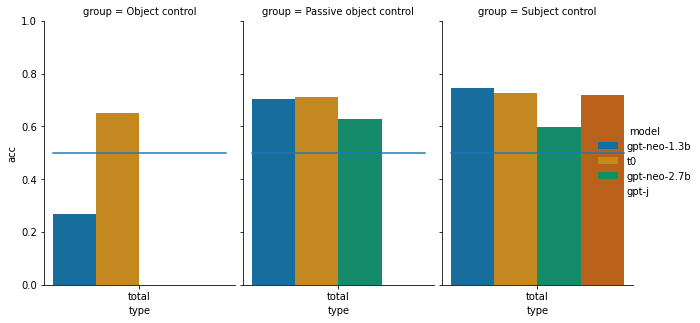

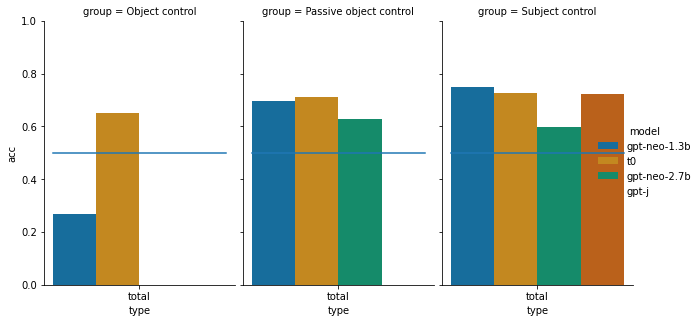

In [5]:


oc_csvs=[
    #  "../results_hacked_to_plot/gpt_object_control_swap_names.csv", 
     "../results_hacked_to_plot/gpt_neo_1.3b_object_control.csv", 
    #  "../results_hacked_to_plot/gpt_neo_2.7b_object_control.csv", 
    #  "../results_hacked_to_plot/gpt_j_object_control.csv", 
    #  "../results_hacked_to_plot/jurassic_object_control_swap_names.csv", 
    #  "../results_hacked_to_plot/jurassic_jumbo_object_control_swap_names.csv", 
     "../results_hacked_to_plot/t0_object_control.csv"
     ]

sc_csvs=[
    #  "../results_hacked_to_plot/gpt_subject_control_swap_names.csv", 
     "../results_hacked_to_plot/gpt_neo_1.3b_subject_control.csv",
     "../results_hacked_to_plot/gpt_neo_2.7b_subject_control.csv", 
     "../results_hacked_to_plot/gpt_j_subject_control.csv",
    #  "../results_hacked_to_plot/jurassic_subject_control_swap_names.csv", 
    #  "../results_hacked_to_plot/jurassic_jumbo_subject_control_swap_names.csv", 
     "../results_hacked_to_plot/t0_subject_control.csv"
     ]

poc_csvs=[
    #  "../results_hacked_to_plot/gpt_passive_object_control_swap_names.csv", 
     "../results_hacked_to_plot/gpt_neo_1.3b_passive_object_control.csv",
     "../results_hacked_to_plot/gpt_neo_2.7b_passive_object_control.csv",
    #  "../results_hacked_to_plot/gpt_j_passive_object_control.csv",
    #  "../results_hacked_to_plot/jurassic_passive_object_control_swap_names.csv", 
    #  "../results_hacked_to_plot/jurassic_jumbo_passive_object_control_swap_names.csv", 
     "../results_hacked_to_plot/t0_passive_object_control.csv"
     ]

csv_data = {"Object control": oc_csvs, "Passive object control": poc_csvs, "Subject control": sc_csvs}
# csv_data = {"Object control": [oc_csvs[3]]}
# g = barplot(csv_data, level="total", x_name = "type", hue_name = "model", filtered=False)
# g.figure.set_size_inches(9.5, 4.5)

g = barplot(csv_data, level="total", x_name = "type", hue_name = "model", filtered=True)
g.figure.set_size_inches(9.5, 4.5)

g = barplot(csv_data, level="total", x_name = "type", hue_name = "model", filtered=True, ignore_first_only=True)
g.figure.set_size_inches(9.5, 4.5)

sns.despine()

## Just the prompt, Agent
How well does each model do on identying just the agent/patient of the matrix clause 

In [2]:
# Recompute Object Control with Just Prompts for Agent
import json 
import pathlib 
from experiment import Experiment
from metrics import accuracy_report
prompt=None
wrapper_fxn=None
nicknames = json.load(open("../data/nicknames.json"))
csvs = [
    #  "../results_hacked/gpt_object_control_swap_names.csv", 
    #  "../results_just_prompt_agent/gpt_neo_1.3b_object_control.csv", 
     "../results_just_prompt_agent/gpt_neo_2.7b_object_control.csv", 
    #  "../results_just_prompt_agent/gpt_j_object_control.csv", 
    #  "../results_just_prompt_agent/jurassic_object_control_swap_names.csv",
    #  "../results_just_prompt_agent/jurassic_jumbo_object_control_swap_names.csv", 
    #  "../results_just_prompt_agent/t5_object_control.csv",
     "../results_just_prompt_agent/t0_object_control.csv"
     ]

# names = ["gpt", "gpt-neo-1.3b", "gpt-neo-2.7b", "gpt-j", "jurassic-large", "jurassic-jumbo", "t5_qa", "t0"]
names = ["gpt-neo-2.7b", "t0"]
recompute(csvs, names, nicknames, exp_name='object-control', results_path="results_just_prompt_agent_to_plot", use_action=False, use_verb=True, correct_idx = 0)

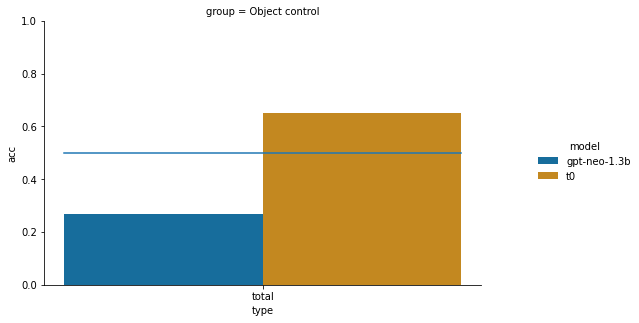

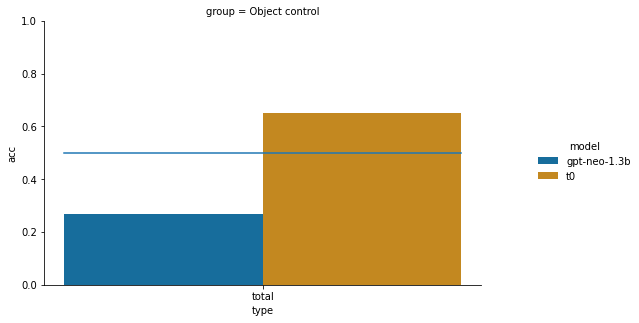

In [3]:


oc_csvs=[
    #  "../results_hacked_to_plot/gpt_object_control_swap_names.csv", 
     "../results_hacked_to_plot/gpt_neo_1.3b_object_control.csv", 
    #  "../results_hacked_to_plot/gpt_neo_2.7b_object_control.csv", 
    #  "../results_hacked_to_plot/gpt_j_object_control.csv", 
    #  "../results_hacked_to_plot/jurassic_object_control_swap_names.csv", 
    #  "../results_hacked_to_plot/jurassic_jumbo_object_control_swap_names.csv", 
     "../results_hacked_to_plot/t0_object_control.csv"
     ]

# sc_csvs=[
#     #  "../results_hacked_to_plot/gpt_subject_control_swap_names.csv", 
#      "../results_hacked_to_plot/gpt_neo_1.3b_subject_control.csv",
#      "../results_hacked_to_plot/gpt_neo_2.7b_subject_control.csv", 
#      "../results_hacked_to_plot/gpt_j_subject_control.csv",
#     #  "../results_hacked_to_plot/jurassic_subject_control_swap_names.csv", 
#     #  "../results_hacked_to_plot/jurassic_jumbo_subject_control_swap_names.csv", 
#      "../results_hacked_to_plot/t0_subject_control.csv"
#      ]

# poc_csvs=[
#     #  "../results_hacked_to_plot/gpt_passive_object_control_swap_names.csv", 
#      "../results_hacked_to_plot/gpt_neo_1.3b_passive_object_control.csv",
#      "../results_hacked_to_plot/gpt_neo_2.7b_passive_object_control.csv",
#     #  "../results_hacked_to_plot/gpt_j_passive_object_control.csv",
#     #  "../results_hacked_to_plot/jurassic_passive_object_control_swap_names.csv", 
#     #  "../results_hacked_to_plot/jurassic_jumbo_passive_object_control_swap_names.csv", 
#     #  "../results_hacked_to_plot/t0_passive_object_control.csv"
#      ]

# csv_data = {"Object control": oc_csvs, "Passive object control": poc_csvs, "Subject control": sc_csvs}
csv_data = {"Object control": oc_csvs}
# g = barplot(csv_data, level="total", x_name = "type", hue_name = "model", filtered=False)
# g.figure.set_size_inches(9.5, 4.5)

g = barplot(csv_data, level="total", x_name = "type", hue_name = "model", filtered=True)
g.figure.set_size_inches(9.5, 4.5)

g = barplot(csv_data, level="total", x_name = "type", hue_name = "model", filtered=True, ignore_first_only=True)
g.figure.set_size_inches(9.5, 4.5)

sns.despine()

In [6]:
# Recompute Object Control with Just Prompts for pateint
import json 
import pathlib 
from experiment import Experiment
from metrics import accuracy_report
prompt=None
wrapper_fxn=None
nicknames = json.load(open("../data/nicknames.json"))
csvs = [
    #  "../results_just_prompt_patient/gpt_object_control_swap_names.csv", 
     "../results_just_prompt_patient/gpt_neo_1.3b_object_control.csv", 
     "../results_just_prompt_patient/gpt_neo_2.7b_object_control.csv", 
    #  "../results_just_prompt_patient/gpt_j_object_control.csv", 
    #  "../results_just_prompt_patient/jurassic_object_control_swap_names.csv",
    #  "../results_just_prompt_patient/jurassic_jumbo_object_control_swap_names.csv", 
    #  "../results_just_prompt_patient/t5_object_control.csv",
     "../results_just_prompt_patient/t0_object_control.csv"
     ]

# names = ["gpt", "gpt-neo-1.3b", "gpt-neo-2.7b", "gpt-j", "jurassic-large", "jurassic-jumbo", "t5_qa", "t0"]
names = ["gpt-neo-1.3b", "gpt-neo-2.7b",  "t0"]
recompute(csvs, names, nicknames, exp_name='object-control', results_path="results_just_prompt_patient_to_plot", use_action=False, use_verb=True, correct_idx = 1)

FileNotFoundError: [Errno 2] No such file or directory: '../results_just_prompt_patient/gpt_neo_2.7b_object_control.csv'

In [8]:
# Recompute Object Control with Just Prompts for pateint
import json 
import pathlib 
from experiment import Experiment
from metrics import accuracy_report
prompt=None
wrapper_fxn=None
nicknames = json.load(open("../data/nicknames.json"))
csvs = [
    #  "../results_just_prompt_patient/gpt_subject_control_swap_names.csv", 
     "../results_just_prompt_patient/gpt_neo_1.3b_subject_control.csv", 
     "../results_just_prompt_patient/gpt_neo_2.7b_subject_control.csv", 
     "../results_just_prompt_patient/gpt_j_subject_control.csv", 
    #  "../results_just_prompt_patient/jurassic_subject_control_swap_names.csv",
    #  "../results_just_prompt_patient/jurassic_jumbo_subject_control_swap_names.csv", 
    #  "../results_just_prompt_patient/t5_subject_control.csv",
     "../results_just_prompt_patient/t0_subject_control.csv"
     ]

# names = ["gpt", "gpt-neo-1.3b", "gpt-neo-2.7b", "gpt-j", "jurassic-large", "jurassic-jumbo", "t5_qa", "t0"]
names = ["gpt-neo-1.3b", "gpt-neo-2.7b", "gpt-j", "t0"]
recompute(csvs, names, nicknames, exp_name='subject-control', results_path="results_just_prompt_patient_to_plot", use_action=False, use_verb=True, correct_idx = 1)

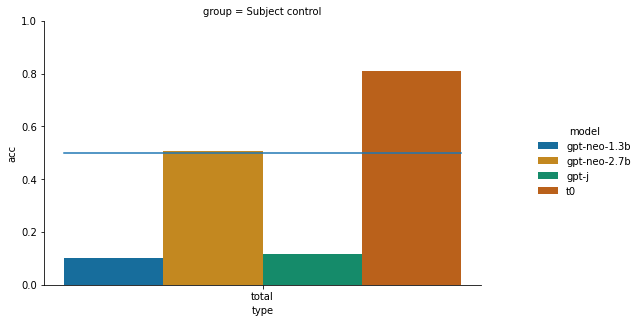

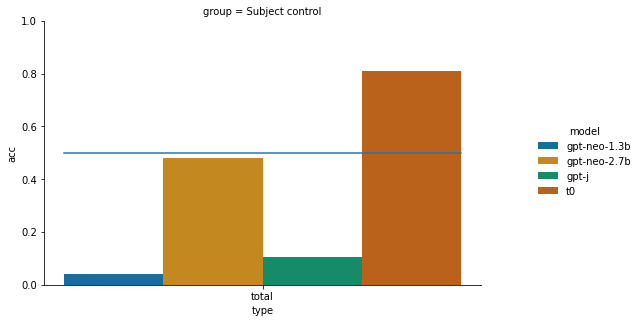

In [11]:


# oc_csvs=[
#     #  "../results_hacked_to_plot/gpt_object_control_swap_names.csv", 
#      "../results_hacked_to_plot/gpt_neo_1.3b_object_control.csv", 
#     #  "../results_hacked_to_plot/gpt_neo_2.7b_object_control.csv", 
#     #  "../results_hacked_to_plot/gpt_j_object_control.csv", 
#     #  "../results_hacked_to_plot/jurassic_object_control_swap_names.csv", 
#     #  "../results_hacked_to_plot/jurassic_jumbo_object_control_swap_names.csv", 
#      "../results_hacked_to_plot/t0_object_control.csv"
#      ]

sc_csvs=[
    #  "../results_just_prompt_patient_to_plot/gpt_subject_control_swap_names.csv", 
     "../results_just_prompt_patient_to_plot/gpt_neo_1.3b_subject_control.csv",
     "../results_just_prompt_patient_to_plot/gpt_neo_2.7b_subject_control.csv", 
     "../results_just_prompt_patient_to_plot/gpt_j_subject_control.csv",
    #  "../results_just_prompt_patient_to_plot/jurassic_subject_control_swap_names.csv", 
    #  "../results_just_prompt_patient_to_plot/jurassic_jumbo_subject_control_swap_names.csv", 
     "../results_just_prompt_patient_to_plot/t0_subject_control.csv"
     ]

# poc_csvs=[
#     #  "../results_hacked_to_plot/gpt_passive_object_control_swap_names.csv", 
#      "../results_hacked_to_plot/gpt_neo_1.3b_passive_object_control.csv",
#      "../results_hacked_to_plot/gpt_neo_2.7b_passive_object_control.csv",
#     #  "../results_hacked_to_plot/gpt_j_passive_object_control.csv",
#     #  "../results_hacked_to_plot/jurassic_passive_object_control_swap_names.csv", 
#     #  "../results_hacked_to_plot/jurassic_jumbo_passive_object_control_swap_names.csv", 
#     #  "../results_hacked_to_plot/t0_passive_object_control.csv"
#      ]

# csv_data = {"Object control": oc_csvs, "Passive object control": poc_csvs, "Subject control": sc_csvs}
csv_data = {"Subject control": sc_csvs}
# g = barplot(csv_data, level="total", x_name = "type", hue_name = "model", filtered=False)
# g.figure.set_size_inches(9.5, 4.5)

g = barplot(csv_data, level="total", x_name = "type", hue_name = "model", filtered=True)
g.figure.set_size_inches(9.5, 4.5)

g = barplot(csv_data, level="total", x_name = "type", hue_name = "model", filtered=True, ignore_first_only=True)
g.figure.set_size_inches(9.5, 4.5)

sns.despine()